In [1]:
###### MANUAL METHOD #######
#note: for this to work you need to create a symbolic link to the fastai/old/fastai folder in the fastai github repo:
# in administrator mode, navigate to this folder in the comand prompt then type the following command 
# $ mklink /d fastai "C:\Users\Dean Procter\_github\fastai\old\fastai" <<<---- path of fastai\old\fastai 
#MORE INFO AT#
#e.g. https://forums.fast.ai/t/howto-installation-on-windows/10439
#e.g. https://superuser.com/questions/1020821/how-to-create-a-symbolic-link-on-windows-10

###### CODE METHOD #########
import os
FASTAI_PATH = r"C:\Users\Dean Procter\_github\fastai\old\fastai" #this is the path of your general models folder, alwasys put that r in from of the string! 
CURRENT_PATH = os.getcwd() #to get the current directory
print(f'This is your current directory: {CURRENT_PATH}')
CURRENT_PATH_FASTAI = os.path.join(CURRENT_PATH, "fastai")
print(f'Symbolic link to fastai created: {CURRENT_PATH_FASTAI}')
os.symlink(FASTAI_PATH, CURRENT_PATH_FASTAI)

This is your current directory: G:\117\117_20190707_H3K9me3quant_repKrepL\_pipeline\v1
Symbolic link to fastai created: G:\117\117_20190707_H3K9me3quant_repKrepL\_pipeline\v1\fastai


## Image classification with Convolutional Neural Networks

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [5]:
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [6]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [7]:
torch.backends.cudnn.enabled

True

In [8]:
#go to the folder with your trained model
PATH = r"G:\117\117_20190601_H3K9me3quant_repE\_pipeline\v1\_training_v2"
os.listdir(PATH)

['117_20190601_H3K9me3quant_repE_v1_CNNexport',
 '117_20190601_H3K9me3quant_repG_v1_CNNexport',
 '117_20190704_H3K9me3quant_repI_v1_CNNexport',
 '117_20190707_H3K9me3quant_repL_v1_CNNexport',
 'models',
 'tmp',
 'train',
 'valid',
 '_manuallysorted']

In [10]:
CNN_export_folder = "117_20190707_H3K9me3quant_repL_v1_CNNexport"
files = os.listdir(f'{PATH}\\{CNN_export_folder}')
#files

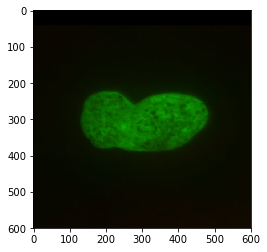

In [11]:
img = plt.imread(f'{PATH}\\{CNN_export_folder}\\{files[0]}')
img
plt.imshow(img);

Here is how the raw data looks like

In [12]:
img.shape

(600, 600, 3)

# train the model

In [13]:
arch=resnet34

In [14]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1) #CHANGED AUGMENTATIONS FROM transforms_side_on

In [15]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[0]

In [16]:
ims = np.stack([get_augs() for i in range(6)])

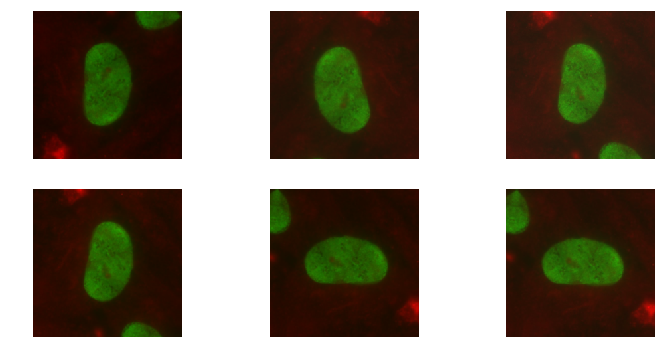

In [17]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [18]:
#change the test name here to the folder name you created for your exported JPEGS
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name=CNN_export_folder)
learn = ConvLearner.pretrained(arch, data, precompute=False)
# To get this to work i maintained the original structure of the training/validation dataset

# PREDICTIONS

In [19]:
os.listdir(PATH+"\models")

['117_20190601_H3K9me3quant_repE_v1.h5']

In [20]:
model_name = '117_20190601_H3K9me3quant_repE_v1'
learn.load(model_name)

In [21]:
#skipped, perhaps can delete
#learn.precompute=False

In [22]:
#sometimes this fails, just try again
preds = learn.predict(is_test = True)

In [23]:
test_files = data.test_dl.dataset.fnames

In [24]:
preds

array([[ -0.0109 ,  -7.25003,  -6.22801,  -4.82597,  -8.96249, -11.21336],
       [ -0.00434,  -8.08229,  -6.80747,  -6.60836,  -6.46084, -16.17038],
       [ -9.81663,  -8.60279,  -9.05602,  -8.52047,  -6.23949,  -0.00251],
       ...,
       [ -0.30777,  -4.56383,  -1.39262,  -5.98531,  -6.76956,  -6.03018],
       [ -0.64469,  -4.88757,  -1.56377,  -6.15467,  -1.3629 ,  -8.31229],
       [ -7.39681,  -6.66502,  -6.08437,  -8.27529,  -7.47207,  -0.005  ]], dtype=float32)

In [25]:
#test_files

In [26]:
learn.precompute=False

In [27]:
#show me the classes in our model
data.classes

['MOCK', 'TB_early', 'TB_perfect', 'blur', 'crap', 'overlap']

In [28]:
#show me the filenames in our test dataset
#data.test_ds.fnames

In [29]:
# get prediction on the test dataset rather than validation dataset
log_preds, y = learn.TTA(is_test=True) 

In [30]:
probs = np.mean(np.exp(log_preds),0)

In [31]:
probs.shape

(18689, 6)

In [32]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [33]:
df.insert(0, 'id', [o for o in data.test_ds.fnames])
#df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [34]:
df.head()

,id,MOCK,TB_early,TB_perfect,blur,crap,overlap
0,117_20190707_H3K9me3quant_repL_v1_CNNexport\11...,0.953890,0.001106,0.032299,0.010455,0.002208,0.000042
1,117_20190707_H3K9me3quant_repL_v1_CNNexport\11...,0.756129,0.000911,0.003174,0.003031,0.236753,0.000002
2,117_20190707_H3K9me3quant_repL_v1_CNNexport\11...,0.011947,0.010030,0.054140,0.006751,0.325591,0.591542
3,117_20190707_H3K9me3quant_repL_v1_CNNexport\11...,0.049838,0.019805,0.022157,0.021519,0.218629,0.668052
4,117_20190707_H3K9me3quant_repL_v1_CNNexport\11...,0.362031,0.008850,0.023361,0.538138,0.067517,0.000103


In [35]:
#strip prefix from filename to match UNIQUE ID
df["id"].replace(regex=True,inplace=True,to_replace=CNN_export_folder + '\\\\',value='')
df["id"].replace(regex=True,inplace=True,to_replace='.jpg',value='') #or coud cut with [0:-4] in df.insert above

In [36]:
df.head()

,id,MOCK,TB_early,TB_perfect,blur,crap,overlap
0,117_20190707_repL_96hpi_1000_1_RGB,0.953890,0.001106,0.032299,0.010455,0.002208,0.000042
1,117_20190707_repL_96hpi_1000_2_RGB,0.756129,0.000911,0.003174,0.003031,0.236753,0.000002
2,117_20190707_repL_96hpi_1000_3_RGB,0.011947,0.010030,0.054140,0.006751,0.325591,0.591542
3,117_20190707_repL_96hpi_1000_4_RGB,0.049838,0.019805,0.022157,0.021519,0.218629,0.668052
4,117_20190707_repL_96hpi_1000_5_RGB,0.362031,0.008850,0.023361,0.538138,0.067517,0.000103


In [37]:
probs_csv_name = CNN_export_folder + "_usingMODEL_" + model_name + ".csv"
df.to_csv(probs_csv_name, index=False)

In [38]:
#START HERE IF YOU DON'T WANT TO DO THE PREDICTIONS AGAIN
import pandas as pd
import sys
import os
from os import listdir
import shutil
import datetime

In [39]:
#uncomment this to load csv
#df = pd.read_csv("117_20190112_v1Ca_CNN_predictions.csv")

In [40]:
#let's check that our data looks good
df.head()

,id,MOCK,TB_early,TB_perfect,blur,crap,overlap
0,117_20190707_repL_96hpi_1000_1_RGB,0.953890,0.001106,0.032299,0.010455,0.002208,0.000042
1,117_20190707_repL_96hpi_1000_2_RGB,0.756129,0.000911,0.003174,0.003031,0.236753,0.000002
2,117_20190707_repL_96hpi_1000_3_RGB,0.011947,0.010030,0.054140,0.006751,0.325591,0.591542
3,117_20190707_repL_96hpi_1000_4_RGB,0.049838,0.019805,0.022157,0.021519,0.218629,0.668052
4,117_20190707_repL_96hpi_1000_5_RGB,0.362031,0.008850,0.023361,0.538138,0.067517,0.000103


In [44]:
df_cnn_pred = df
total_cells = str(df_cnn_pred.shape[0])
print("Number of cells in full dataset: "+ total_cells)
cat_labels = df_cnn_pred.columns[1:]
print("Classification labels:")
for x in cat_labels:
    print("-->"+ x)

Number of cells in full dataset: 18689
Classification labels:
-->MOCK
-->TB_early
-->TB_perfect
-->blur
-->crap
-->overlap
-->cnnsort_cat


In [45]:
#### TRY TO ADD A PROGRESS BAR TO THIS AS IT CAN TAKE QUITE SOME TIME ###
#e.g. https://github.com/tqdm/tqdm#ipython-jupyter-integration

#just copy the path for now from the folder used as TEST
#### TRY TO REMOVE THE NECESSITY OF THIS DEFINITION AS IT IS ALREADY DEFINED ABOVE
test_folder_path = f'{PATH}\\{CNN_export_folder}'

confidence_cutoff_values = [0.99,0.90,0.80,0.70,0.60,0.50]

foldername = "CNNpredictions_" + datetime.datetime.now().strftime('%Y%m%d_%H%M')
mydir = os.path.join(os.getcwd(), foldername)
os.makedirs(mydir)

for cutoff_val in confidence_cutoff_values:
    
    def label_cat (row):
        if row['MOCK'] >= cutoff_val :
          return 'MOCK'
        if row['TB_perfect'] >= cutoff_val :
          return 'TB_perfect'
        if row['blur'] >= cutoff_val :
          return 'blur'
        if row['crap'] >= cutoff_val :
          return 'crap'
        if row['overlap'] >= cutoff_val :
          return 'overlap'
        if row['TB_early'] >= cutoff_val :
          return 'TB_early'
        return 'FALSE'
    
    colname = str(int(cutoff_val*100)) + "confidence"
    df_cnn_pred['cnnsort_cat'] = df_cnn_pred.apply (lambda row: label_cat (row),axis=1)
    df_cnn_pred_sort = df_cnn_pred[df_cnn_pred.cnnsort_cat != "FALSE"]    
    proportion_of_dataset = 100 - (int(total_cells) - int(df_cnn_pred_sort.shape[0]))/int(total_cells)*100
    
    print("\rSorting for {}% confidence, representing {}% of the total dataset".format(cutoff_val*100,int(proportion_of_dataset)), end="", flush=True)

    cat_val = df_cnn_pred_sort.cnnsort_cat.unique()
    cat_val = df_cnn_pred_sort.cnnsort_cat.unique()
    for cats in cat_val:
        os.makedirs(os.path.join(mydir,colname,cats))
    
    list_fn=[]
    #### THIS DOESNT WORK 
    #this will scan through the training dataset and only add files that aren't in the training dataset to the CNN predictions, comment this out if you want these
    #for r,d,f in os.walk(test_folder_path):
        #for file in f:
         #   list_fn.append(file)    
    ######
    
    #this will scan through the higher confidence folders and only add files that are unique to the lower datasets
    for r,d,f in os.walk(mydir):
        for file in f:
            list_fn.append(file) 
    
    for index, rows in df_cnn_pred_sort.iterrows():
        fn = rows.id + ".jpg"
        if fn not in list_fn:
            cnnsort_cat = rows.cnnsort_cat
            new_filename = os.path.join(mydir, colname , cnnsort_cat, fn)
            old_filename = os.path.join(test_folder_path, fn)
            shutil.copy(old_filename, new_filename)
    
    

Sorting for 50.0% confidence, representing 91% of the total dataset

In [43]:
import smtplib, ssl

port = 465  # For SSL
smtp_server = "smtp.gmail.com"
sender_email = "USERNAME@gmail.com" # Enter your address
password = "PASSWORD"
#password = input("Type your password and press enter: ")

receiver_email = "RECEIVER_EMAIL_ADDRESS@gmail.com"  # Enter receiver address

message = f"""\
Subject: {CNN_export_folder} pipeline complete

This message is sent from Python."""

context = ssl.create_default_context()
with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, message)